# fMRI Demo (SPM version)

## Introduction

This is an example of RSA on a fMRI dataset that was analyzed with SPM. The data is described in the following papers:
- Diedrichsen, J., Wiestler, T., & Krakauer, J. W. W. (2013). Two distinct ipsilateral cortical representations for individuated finger movements. Cerebral Cortex , 23(6), 1362–1377.
- Ejaz, N., Hamada, M., & Diedrichsen, J. (2015). Hand use predicts the structure of representations in sensorimotor cortex. Nature Neuroscience, 18(7), 1034–1040.

In the paradigm, participants made individual finger presses with one of the 5 fingers of the left or right hand. The data was preprocessed and analyzed with SPM. We are providing and analyzing only one single subject's data here https://www.dropbox.com/scl/fo/94njk5dq80niybi57cfgj/AEfF_YbXg8G50l0xgXPNzEY?rlkey=9v7x4l03xpfjrn1b6tqetw9rf&dl=0. 

This library depends on *nibabel* and *nitools* for convenience functions to access MRI data. So start by installing both packages (`pip install nibabel nitools`).

In [39]:
%matplotlib inline
import os
import numpy as np
import nibabel as nb
import nitools as nt
import pandas as pd
from rsatoolbox.data import Dataset
from rsatoolbox.io.spm import SpmGlm
import rsatoolbox as rsa
import matplotlib.pyplot as plt

### Define the SPM GLM object 
We need to define the directory where the example data is located. 

In [10]:
data_dir = os.path.expanduser('~/Dropbox/projects/rsa_example_dataset')

In [11]:
## Initialize the GLM object from the SPM.mat file
spm=SpmGlm(data_dir + '/glm_firstlevel')
spm.get_info_from_spm_mat()


### RDM from univariate pre-whitened betas

In [21]:
# Get the betas and residual mean-square image for left M1
[beta,ResMS,info]=spm.get_betas(data_dir + '/anat/M1_L.nii')
print(f'Shape of Betas: {beta.shape[0]}x{beta.shape[1]}')

Shape of Betas: 80x362


,reg_name,run_number
0,hand1_digit1*bf(1),1
1,hand1_digit2*bf(1),1
2,hand1_digit3*bf(1),1
3,hand1_digit4*bf(1),1
4,hand1_digit5*bf(1),1
...,...,...
75,hand2_digit1*bf(1),8
76,hand2_digit2*bf(1),8
77,hand2_digit3*bf(1),8
78,hand2_digit4*bf(1),8


In [32]:
# Extract digit and hand number from regressor names
info = pd.DataFrame(info)
info['hand']=[int(r[4]) for r in info['reg_name']]
info['digit']=[int(r[11]) for r in info['reg_name']]
info['condition']=(info['hand']-1)*5+info['digit']
info

,reg_name,run_number,hand,digit,condition
0,hand1_digit1*bf(1),1,1,1,1
1,hand1_digit2*bf(1),1,1,2,2
2,hand1_digit3*bf(1),1,1,3,3
3,hand1_digit4*bf(1),1,1,4,4
4,hand1_digit5*bf(1),1,1,5,5
...,...,...,...,...,...
75,hand2_digit1*bf(1),8,2,1,6
76,hand2_digit2*bf(1),8,2,2,7
77,hand2_digit3*bf(1),8,2,3,8
78,hand2_digit4*bf(1),8,2,4,9


In [33]:
# Get a RSA dataset from the univariate prewhitened betas
data = Dataset(
            measurements=beta/np.sqrt(ResMS),
            obs_descriptors=dict(info)
)

In [38]:
RDM = rsa.rdm.calc_rdm(
    data,
    method='crossnobis',
    descriptor='condition',
    cv_descriptor='run_number')

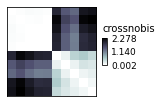

In [42]:
fig, _, _ = rsa.vis.show_rdm(RDM, show_colorbar='panel')
plt.show()

In [ ]:
dims = run.get_data(masked=True).shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(61476, 546)

Access the attributes stored in the *_metadata.json* for this file

In [ ]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

We will also load the events table

In [ ]:
run.get_events().sample(5) ## 5 random events



** The rest of the tutorial to be implemented for SPM **


the "IT" mask is at demos/ctx-rh-inferiortemporal.nii.gz